In [ ]:
%cd /content/drive/Shareddrives/CSE544_Project/covid_dataset
!ls

/content/drive/Shareddrives/CSE544_Project/covid_dataset
backup
colab_pdf.py
COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv
covid_la_cleaned.csv
covid_la_cleaned_removed_outliers.csv
covid_md_cleaned.csv
covid_md_cleaned_removed_outliers.csv
__pycache__
United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv
vacc_la_clean.csv
vacc_la_clean_removed_outliers.csv
vacc_md_clean.csv
vacc_md_clean_removed_outliers.csv


In [ ]:
#importing all libraries
import pandas as pd
import numpy as np
from collections import Counter
import math
import csv
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Taking LA and MD covid dataframes with only cases per day
df_covid_la = pd.read_csv('covid_la_cleaned_removed_outliers.csv')
df_covid_md = pd.read_csv('covid_md_cleaned_removed_outliers.csv')

In [ ]:
# daily stats from new cases and new deaths for la and md
df_covid_md['daily_stats'] = df_covid_md['new_case'] + df_covid_md['new_death']
df_covid_la['daily_stats'] = df_covid_la['new_case'] + df_covid_la['new_death']

In [ ]:
# Getting data starting from June 1 2020 for both md and la
df_covid_la['submission_date'] = pd.to_datetime(df_covid_la['submission_date'])
df_covid_md['submission_date'] = pd.to_datetime(df_covid_md['submission_date'])
df_covid_la['week'] = df_covid_la['submission_date'].dt.week
df_covid_md['week'] = df_covid_md['submission_date'].dt.week
df_covid_md = df_covid_md.loc[(df_covid_md['submission_date'] >= '2020-06-01') & (df_covid_md['submission_date'] <= '2020-07-26')]
df_covid_la = df_covid_la.loc[(df_covid_la['submission_date'] >= '2020-06-01') & (df_covid_la['submission_date'] <= '2020-07-26')]
df_covid_la = df_covid_la.sort_values(by='submission_date')
df_covid_md = df_covid_md.sort_values(by='submission_date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [ ]:
# Estimating lamnda MME using data available for first 28 days of June. Some records may be removed during outlier removal, so we maintian a counter.
def compute_lambda_mme(df, num_days=28):
  lambda_mme = 0.0
  count = 0
  for i, row in df.iloc[:num_days].iterrows():
    if str(row['submission_date']).split(" ")[0] <= '2020-06-28':
      lambda_mme += row['daily_stats']
      count += 1
  lambda_mme = lambda_mme / count
  return lambda_mme

In [ ]:
# computing lambda MME for md and la data using 1st 28 days data of June
num_days = 28
lambda_mme_md = compute_lambda_mme(df_covid_md, 28)
print("Lambda MME for MD data", lambda_mme_md)
lambda_mme_la = compute_lambda_mme(df_covid_la, 28)
print("Lambda MME for LA data", lambda_mme_la)

Lambda MME for MD data 508.0
Lambda MME for LA data 597.4285714285714


In [ ]:
# Beta (mean) of exponential prior = lambda mme 
# Beta = 1 / lambda(exp prior) = lambda mme
lambda_exp_prior_md = 1.0 / lambda_mme_md
print('Prior Lambda Parameter for MD', lambda_exp_prior_md)
lambda_exp_prior_la = 1.0 / lambda_mme_la
print('Prior Lambda Parameter for LA', lambda_exp_prior_la)

Prior Lambda Parameter for MD 0.001968503937007874
Prior Lambda Parameter for LA 0.0016738402678144427


In [ ]:
# The total sum of daily stats from start date to end date
def get_total(start_date, end_date, df):
  df = df.loc[(df['submission_date'] >= start_date) & (df['submission_date'] <= end_date)]
  return df['daily_stats'].sum(), df.shape[0]

In [ ]:
# Computing alpha and beta parameters of gamma posterior. Using equation as shown in the images below.
def compute_posterior_parmeters(count, running_sum, lambda_mme, num_days):

    alpha = running_sum + 1
    beta = (num_days*count) + (1.0 / lambda_mme)
    
    return alpha, beta


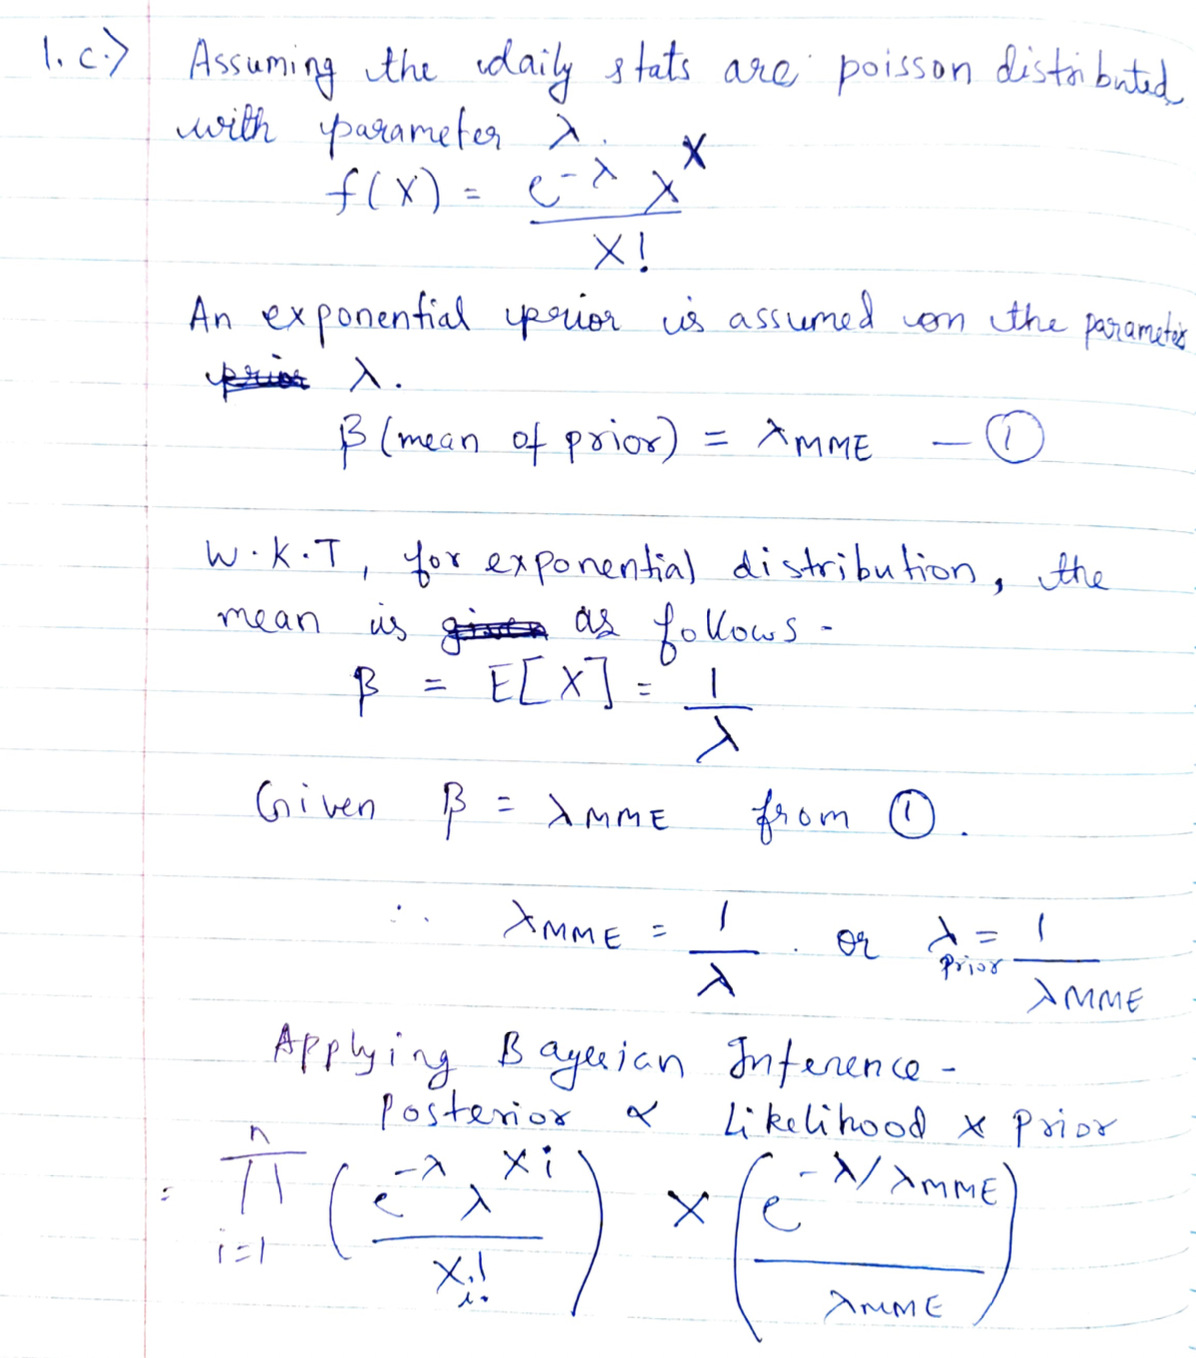

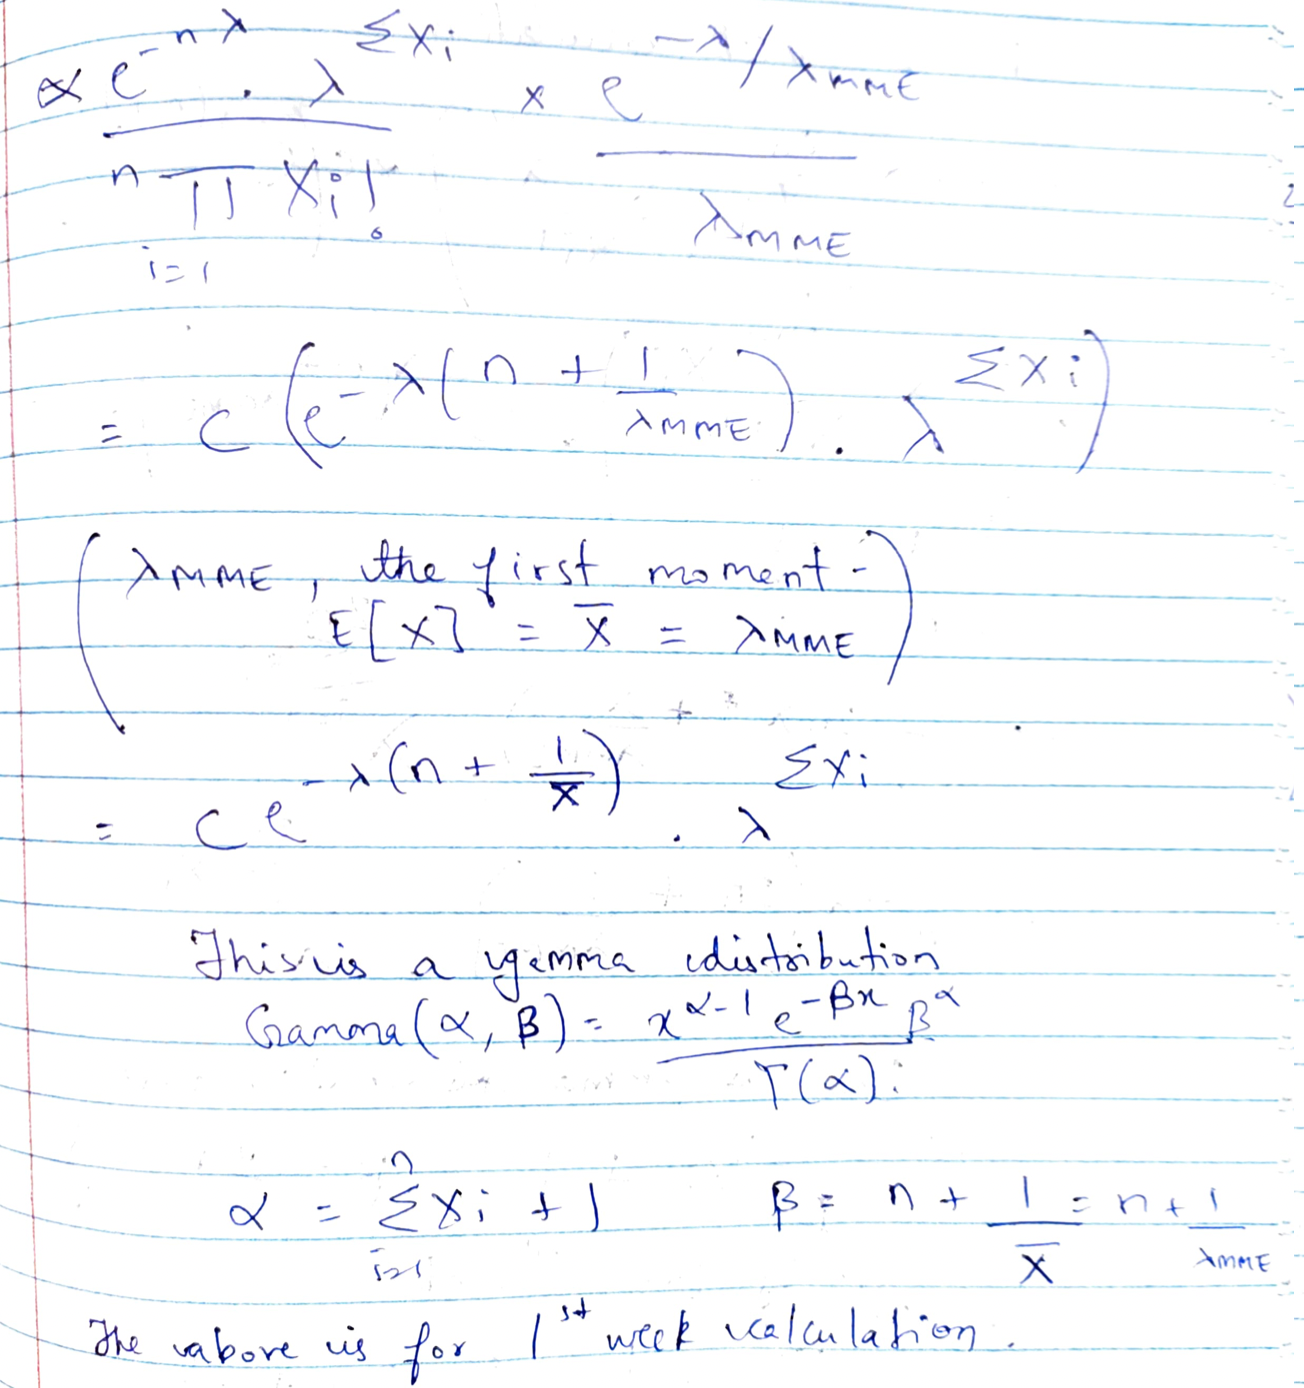

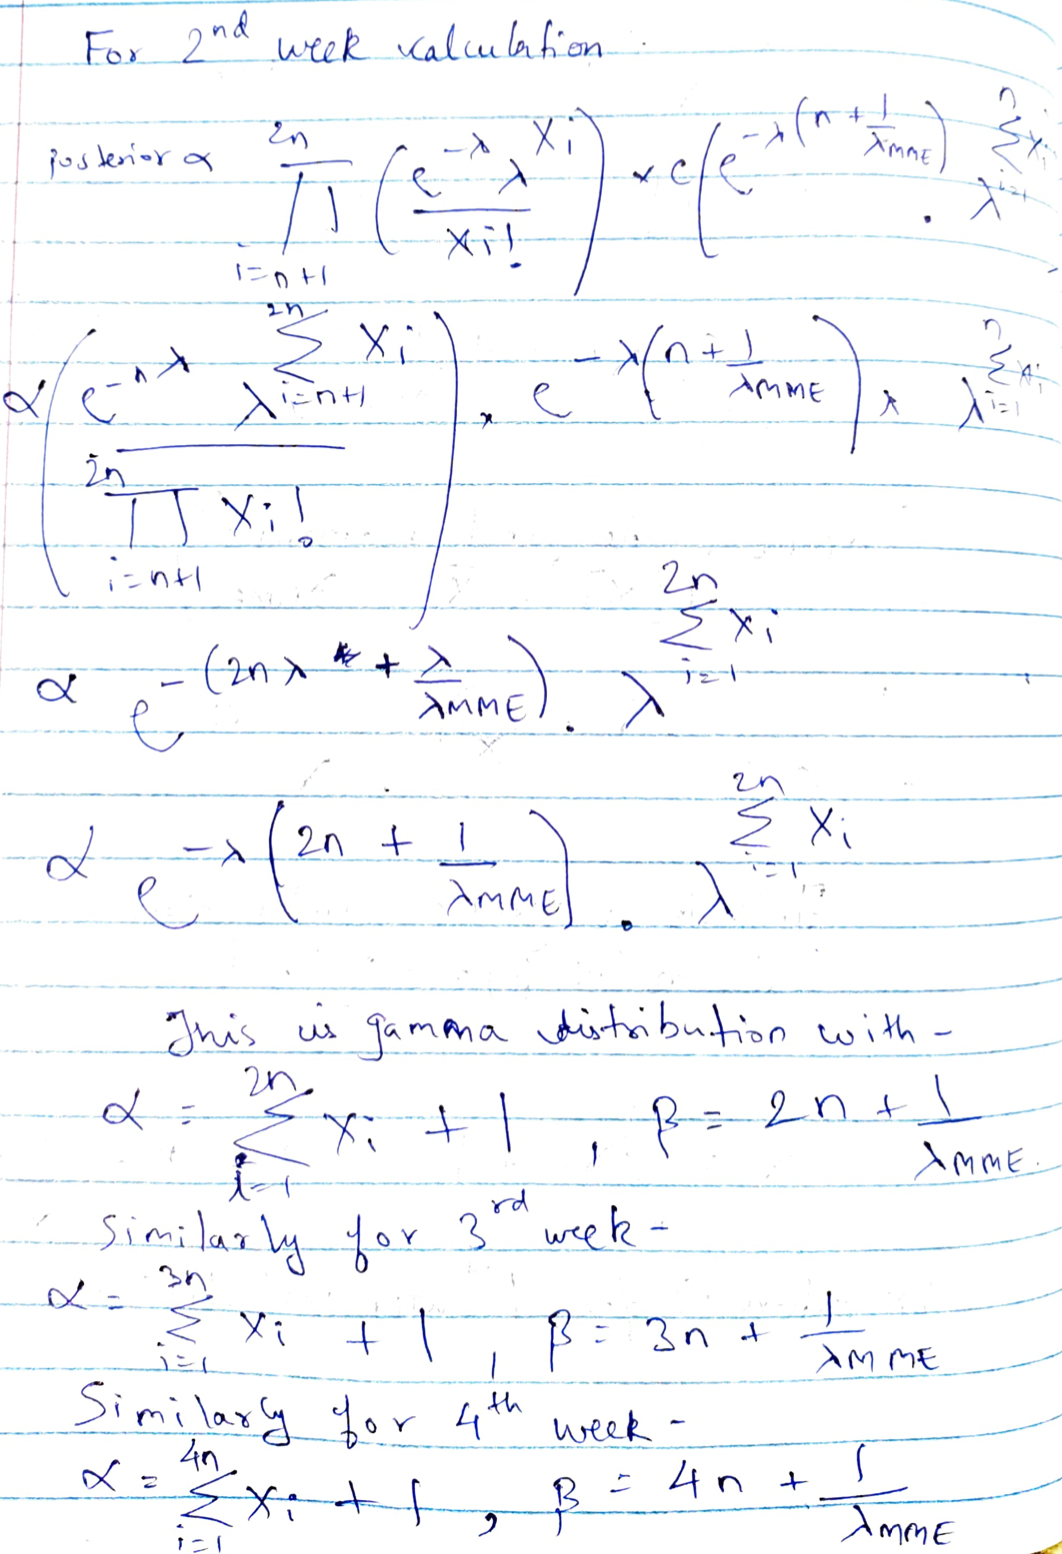

In [ ]:
# Counter for each week (constant for multiplication in computing beta for each weeek)
count = 1
# Running sum is maintained for computing cumilative sums for 1st week, 2nd week so on.
running_sum_md = 0.0
running_sum_la = 0.0

alphas_md, betas_md = [], []
alphas_la, betas_la = [], []

# Computing posterior for 1 week starting 29th June for MD and LA.
cases_weekly_md, num_days_md = get_total('2020-06-29', '2020-07-05', df_covid_md)
cases_weekly_la, num_days_la = get_total('2020-06-29', '2020-07-05', df_covid_la)
running_sum_md += cases_weekly_md
running_sum_la += cases_weekly_la
alpha_md, beta_md = compute_posterior_parmeters(count, running_sum_md, lambda_mme_md, num_days_md)
alphas_md.append(alpha_md)
betas_md.append(beta_md)
alpha_la, beta_la = compute_posterior_parmeters(count, running_sum_la, lambda_mme_la, num_days_la)
alphas_la.append(alpha_la)
betas_la.append(beta_la)


# Computing posterior for 1 week starting 6th July for MD and LA
count += 1
cases_weekly_md, num_days_md = get_total('2020-07-06', '2020-07-12', df_covid_md)
cases_weekly_la, num_days_la = get_total('2020-07-06', '2020-07-12', df_covid_la)
running_sum_md += cases_weekly_md
running_sum_la += cases_weekly_la
alpha_md, beta_md = compute_posterior_parmeters(count, running_sum_md, lambda_mme_md, num_days_md)
alphas_md.append(alpha_md)
betas_md.append(beta_md)
alpha_la, beta_la = compute_posterior_parmeters(count, running_sum_la, lambda_mme_la, num_days_la)
alphas_la.append(alpha_la)
betas_la.append(beta_la)


# Computing posterior for 1 week starting 13th July for MD and LA
count += 1
cases_weekly_md, num_days_md = get_total('2020-07-13', '2020-07-19', df_covid_md)
cases_weekly_la, num_days_la = get_total('2020-07-13', '2020-07-19', df_covid_la)
running_sum_md += cases_weekly_md
running_sum_la += cases_weekly_la
alpha_md, beta_md = compute_posterior_parmeters(count, running_sum_md, lambda_mme_md, num_days_md)
alphas_md.append(alpha_md)
betas_md.append(beta_md)
alpha_la, beta_la = compute_posterior_parmeters(count, running_sum_la, lambda_mme_la, num_days_la)
alphas_la.append(alpha_la)
betas_la.append(beta_la)


# Computing posterior for 1 week starting 20th July for MD and LA
count += 1
cases_weekly_md, num_days_md = get_total('2020-07-20', '2020-07-26', df_covid_md)
cases_weekly_la, num_days_la = get_total('2020-07-20', '2020-07-26', df_covid_la)
running_sum_md += cases_weekly_md
running_sum_la += cases_weekly_la
alpha_md, beta_md = compute_posterior_parmeters(count, running_sum_md, lambda_mme_md, num_days_md)
alphas_md.append(alpha_md)
betas_md.append(beta_md)
alpha_la, beta_la = compute_posterior_parmeters(count, running_sum_la, lambda_mme_la, num_days_la)
alphas_la.append(alpha_la)
betas_la.append(beta_la)

MAP: week-1 Lambda (X-Axis) 420.05276915853227  Gamma PDF(Y-axis) 0.05150371740308224
MAP: week-2 Lambda (X-Axis) 463.3332709279773  Gamma PDF(Y-axis) 0.06935223425170912
MAP: week-3 Lambda (X-Axis) 550.7075857089246  Gamma PDF(Y-axis) 0.07790678549965846
MAP: week-4 Lambda (X-Axis) 615.8990050048415  Gamma PDF(Y-axis) 0.08506188042670558


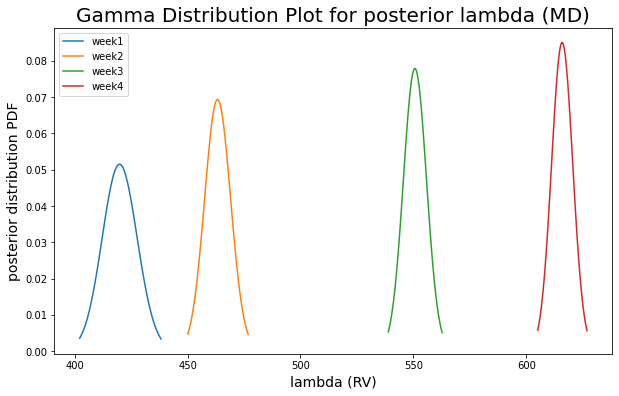

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.xlabel('lambda (RV)', fontsize=14)
plt.ylabel('posterior distribution PDF', fontsize=14)
for i in range(4):
  # Using inverse CDF to find starting points and ending points for x with tail probabilities 0.01 and 0.99.  
  x = np.linspace(stats.gamma.ppf(0.01, alphas_md[i], scale=1/betas_md[i]),stats.gamma.ppf(0.99, alphas_md[i],scale = 1/betas_md[i]), 100)
  y = stats.gamma.pdf(x, a=alphas_md[i], scale=1.0/betas_md[i])
  print("MAP: week-"+str(i+1),"Lambda (X-Axis)", x[np.argmax(y)], " Gamma PDF(Y-axis)", np.max(y))
  #create plot of Gamma distribution
  plt.plot(x, y, label="week" + str(i + 1))

plt.title('Gamma Distribution Plot for posterior lambda (MD)', fontsize=20)
plt.legend()

MAP: week-1 Lambda (X-Axis) 1296.7229963413365  Gamma PDF(Y-axis) 0.029314849308750068
MAP: week-2 Lambda (X-Axis) 1578.5239158274487  Gamma PDF(Y-axis) 0.03757097729202829
MAP: week-3 Lambda (X-Axis) 1705.1985406627443  Gamma PDF(Y-axis) 0.04427034078592738
MAP: week-4 Lambda (X-Axis) 2239.63740754248  Gamma PDF(Y-axis) 0.0376973714852414


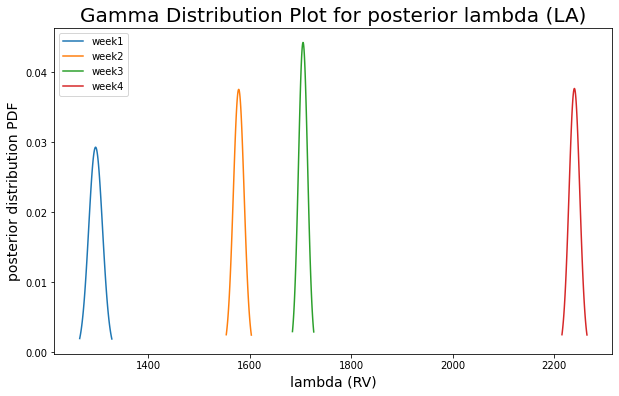

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.xlabel('lambda (RV)', fontsize=14)
plt.ylabel('posterior distribution PDF', fontsize=14)

for i in range(4):
  
  # Using inverse CDF to find starting points and ending points for x with tail probabilities 0.01 and 0.99.  
  x = np.linspace(stats.gamma.ppf(0.01, alphas_la[i], scale=1/betas_la[i]), stats.gamma.ppf(0.99, alphas_la[i],scale = 1/betas_la[i]), 100)
  y = stats.gamma.pdf(x, a=alphas_la[i], scale=1.0/betas_la[i])
  print("MAP: week-"+str(i+1),"Lambda (X-Axis)",x[np.argmax(y)]," Gamma PDF(Y-axis)",np.max(y))
  #create plot of Gamma distribution
  plt.plot(x, y, label="week" + str(i + 1))

plt.title('Gamma Distribution Plot for posterior lambda (LA)', fontsize=20)
plt.legend()

[Text(0.5, 1.0, 'Daily Stats vs week (From Jun-July) in MD')]

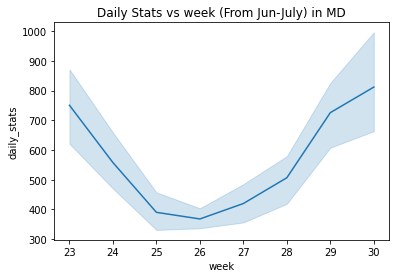

In [ ]:
# June - (23 - 26), July - (27 - 30)
sns.lineplot(data=df_covid_md, x="week", y="daily_stats").set(title='Daily Stats vs week (From Jun-July) in MD')

[Text(0.5, 1.0, 'Daily stats vs week (From Jun-July) in LA')]

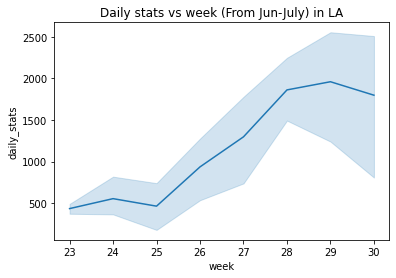

In [ ]:
# June - (23 - 26), July - (27 - 30)
sns.lineplot(data=df_covid_la, x="week", y="daily_stats").set(title='Daily stats vs week (From Jun-July) in LA')

In [1]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic &> /dev/null
!jupyter nbconvert --to pdf /content/drive/Shareddrives/CSE544_Project/part_c/part_c.ipynb  &> /dev/null

**Bayesian Inference Conclusion**

The weekly cases in July is increasing drastically in Lousiana (LA), whereas in Maryland (MD) the cases in July are higher but we do not see as drastic increase as seen in Lousiana. The MME estimation of the parameter lambda was done when the cases were lower in LA during June (as seen in the graph (week 23-26). But the cases in July were much higher, and hence the confidence in posterior estimation decreases. We get highest peak at week 3 and a drop in week 4 for lousiana. We hypothesize that the likelihood of data in the last week (we get covid peak in week 4) under the given paramters was less and hence caused the drop in confidence.